Following Tut for setting up MaskRCNN and based off.
https://gilberttanner.com/blog/getting-started-with-mask-rcnn-in-keras


**Designed to be run in colab.**

Run Cells in order.
1. instert kaggle.json in first cell to download dataset.
2. dataset structure: RootFolder - Train,Test - classes
3. configure config to number of classes


In [ ]:
from google.colab import files
files.upload() # Browse for the kaggle.json file that you downloaded

# Make directory named kaggle, copy kaggle.json file there, and change the permissions of the file.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Download and unzip sign-language-mnist dataset into '/usr/local'
! kaggle datasets download -d johnrenlim/cv-project-flower-dataset --path '/content' --unzip

Saving kaggle.json to kaggle.json
ref                                                          title                                           size  lastUpdated          downloadCount  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
alexgude/california-traffic-collision-data-from-switrs       California Traffic Collision Data from SWITRS    1GB  2020-11-22 16:51:55           1529  
babyoda/women-entrepreneurship-and-labor-force               Women Entrepreneurship and Labor Force           1KB  2020-11-21 08:38:51           3627  
szymonjanowski/internet-articles-data-with-users-engagement  Internet news data with readers engagement       3MB  2020-11-21 17:09:57           1741  
sakshigoyal7/credit-card-customers                           Credit Card customers                          379KB  2020-11-19 07:38:44           6902  
imoore/2020-us-general-election-turnout-rates         

In [ ]:
%tensorflow_version 1.x
!pip3 uninstall -y keras
!pip3 install keras==2.1.0
!git clone https://github.com/matterport/Mask_RCNN
%cd Mask_RCNN
!pip3 install -r requirements.txt
!python3 setup.py install
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!make
%cd ../../

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


... done downloading pretrained model!


In [ ]:
# utils. is a class within Mask RCNN 
class FlowerDataset(utils.Dataset):
    def load_dataset(self, dataset_dir):
        self.add_class('dataset', 1, 'daisy')
        self.add_class('dataset', 2, 'dandelion')
        self.add_class('dataset', 3, 'rose')
        self.add_class('dataset', 4, 'sunflower')
        self.add_class('dataset', 5, 'tulip')
        
        # find all images
        i = 1
        for folder in os.listdir(dataset_dir):
          #print(folder)
          fs = os.listdir(os.path.join(dataset_dir, folder))
          fs_sorted = sorted(fs,key=lambda x: int(os.path.splitext(x)[0])) # needed to sort for error checking
          for filename in fs_sorted:
              if '.jpg' in filename:
                #print(filename)
                self.add_image('dataset', 
                              image_id=i, 
                              path=os.path.join(os.path.join(dataset_dir, folder), filename), 
                              annotation=os.path.join(os.path.join(dataset_dir,folder), filename.replace('.jpg', '.xml')))
                #print(i)
                i+=1 
                
    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ET.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = []
        classes = []
        for member in root.findall('object'):
            xmin = int(member[4][0].text)
            ymin = int(member[4][1].text)
            xmax = int(member[4][2].text)
            ymax = int(member[4][3].text)
            boxes.append([xmin, ymin, xmax, ymax])
            classes.append(self.class_names.index(member[0].text))
        # extract image dimensions
        width = int(root.find('size')[0].text)
        height = int(root.find('size')[1].text)
        return boxes, classes, width, height
 
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        #print(path)
        # load XML  
        boxes, classes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = np.zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
        return masks, np.asarray(classes, dtype='int32')
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

Train: 500
Test: 50


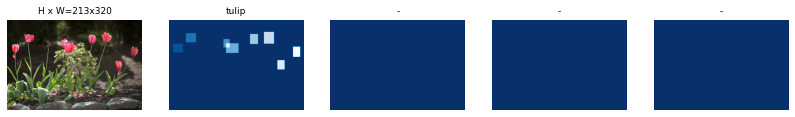

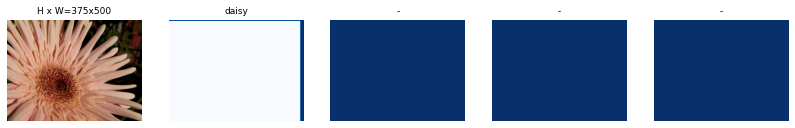

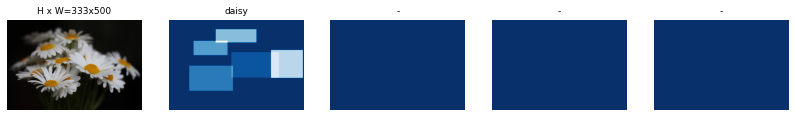

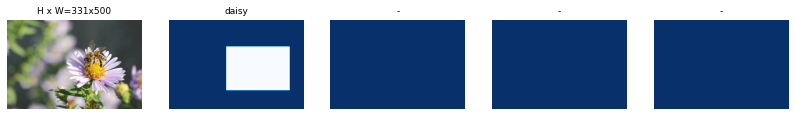

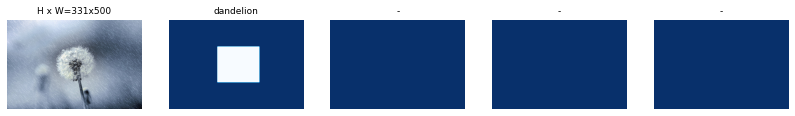

In [ ]:
# Create training and validation set
# train set
dataset_train = FlowerDataset()
dataset_train.load_dataset('../Flower_Detection/train')
dataset_train.prepare()
print('Train: %d' % len(dataset_train.image_ids))

# test/val set
dataset_val = FlowerDataset()
dataset_val.load_dataset('../Flower_Detection/test')
dataset_val.prepare()
print('Test: %d' % len(dataset_val.image_ids))

# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [ ]:
#for img in dataset_train.image_info:
    #print(img)

In [ ]:
class FlowerConfig(Config):
    # Give the configuration a recognizable name
    NAME = "flower_detection"
    STEPS_PER_EPOCH = 1000
    NUM_CLASSES = 1 + 5 # background + classes 
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = FlowerConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')








Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead







Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/flower_detection20201210T1940/mask_rcnn_flower_detection_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcn

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
 999/1000 [============================>.] - ETA: 0s - loss: 1.5272 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 0.3961 - mrcnn_class_loss: 0.3539 - mrcnn_bbox_loss: 0.4056 - mrcnn_mask_loss: 0.3195

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



1000/1000 [==============================] - 639s 639ms/step - loss: 1.5279 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 0.3959 - mrcnn_class_loss: 0.3546 - mrcnn_bbox_loss: 0.4057 - mrcnn_mask_loss: 0.3196 - val_loss: 1.0729 - val_rpn_class_loss: 0.0218 - val_rpn_bbox_loss: 0.2659 - val_mrcnn_class_loss: 0.2340 - val_mrcnn_bbox_loss: 0.2901 - val_mrcnn_mask_loss: 0.2612
Epoch 2/10
1000/1000 [==============================] - 560s 560ms/step - loss: 1.1097 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.3189 - mrcnn_class_loss: 0.2482 - mrcnn_bbox_loss: 0.2360 - mrcnn_mask_loss: 0.2704 - val_loss: 1.1529 - val_rpn_class_loss: 0.0166 - val_rpn_bbox_loss: 0.3495 - val_mrcnn_class_loss: 0.2623 - val_mrcnn_bbox_loss: 0.2591 - val_mrcnn_mask_loss: 0.2655
Epoch 3/10
1000/1000 [==============================] - 558s 558ms/step - loss: 0.9600 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.2768 - mrcnn_class_loss: 0.2041 - mrcnn_bbox_loss: 0.1925 - mrcnn_mask_loss: 0.2554 - val_loss: 1.0935 - val_rpn_cl

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=20, 
            layers="all")



Starting at epoch 10. LR=0.0001

Checkpoint Path: /content/logs/flower_detection20201210T1940/mask_rcnn_flower_detection_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
b

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

Epoch 11/20
 999/1000 [============================>.] - ETA: 0s - loss: 0.4477 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1060 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.1874

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 977s 977ms/step - loss: 0.4476 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1060 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.1874 - val_loss: 0.9186 - val_rpn_class_loss: 0.0209 - val_rpn_bbox_loss: 0.2821 - val_mrcnn_class_loss: 0.2132 - val_mrcnn_bbox_loss: 0.1786 - val_mrcnn_mask_loss: 0.2236
Epoch 12/20
1000/1000 [==============================] - 916s 916ms/step - loss: 0.3912 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.0547 - mrcnn_mask_loss: 0.1784 - val_loss: 1.0861 - val_rpn_class_loss: 0.0170 - val_rpn_bbox_loss: 0.3195 - val_mrcnn_class_loss: 0.2191 - val_mrcnn_bbox_loss: 0.2390 - val_mrcnn_mask_loss: 0.2915
Epoch 13/20
1000/1000 [==============================] - 915s 915ms/step - loss: 0.3648 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0691 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.1721 - val_loss: 1.0093 - val_rpn_c

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Loading weights from  /content/logs/flower_detection20201210T1940/mask_rcnn_flower_detection_0020.h5
Re-starting from epoch 20
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (18,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    4.00000  max:    4.00000  int32
gt_bbox                  shape: (1, 4)                min:   22.00000  max:  818.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


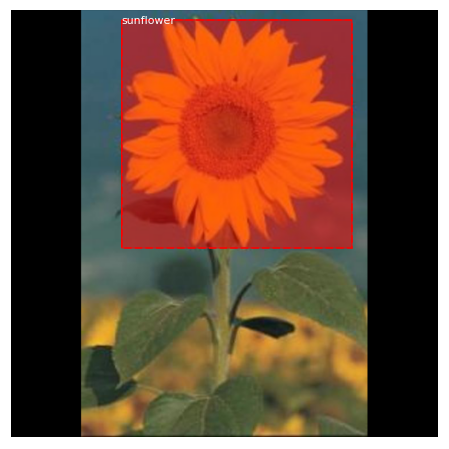

In [ ]:
class InferenceConfig(FlowerConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


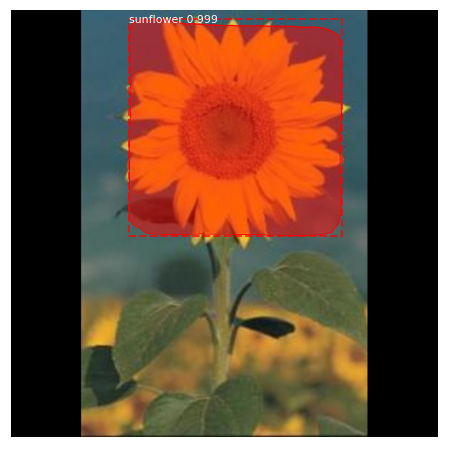

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = dataset_val.image_ids
print(len(image_ids))
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

50
mAP:  0.6758721629842407


In [ ]:
print(precisions)

[1.         1.         1.         0.85714286 0.85714286 0.85714286
 0.85714286 0.85714286 0.8        0.8        0.8        0.72727273
 0.66666667 0.        ]


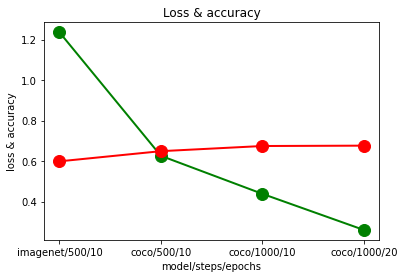

In [1]:
import matplotlib.pyplot as plt

#create lists of x and y values
x = ['imagenet/500/10','coco/500/10','coco/1000/10','coco/1000/20']
y1 = [1.2359, 0.6259, 0.4382, 0.26]
y2 = [0.59859, 0.64876, 0.67424, 0.676]

# keyword arguments
plt.plot(x, y1,color='green', marker='o',
            linewidth=2, markersize=12)
plt.plot(x, y2,color='red', marker='o',
            linewidth=2, markersize=12)

plt.xlabel('model/steps/epochs')
plt.ylabel('loss & accuracy')
plt.title('Loss & accuracy')

# everything is drawn in the background, call show to see it
plt.show()

Processing 1 images
image                    shape: (192, 159, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[{'rois': array([[145,   0, 192,  53],
       [ 82,   5, 144,  60],
       [110,  76, 159, 117],
       [ 84, 108, 142, 156],
       [ 78,  54, 117,  91],
       [  2,  90,  33, 140],
       [ 12,  84,  86, 140]], dtype=int32), 'class_ids': array([1, 1, 1, 1, 1, 1, 1], dtype=int32), 'scores': array([0.9897855, 0.9801933, 0.9692248, 0.9557932, 0.9525551, 0.9316483,
       0.9300737], dtype=float32), 'masks': array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
   

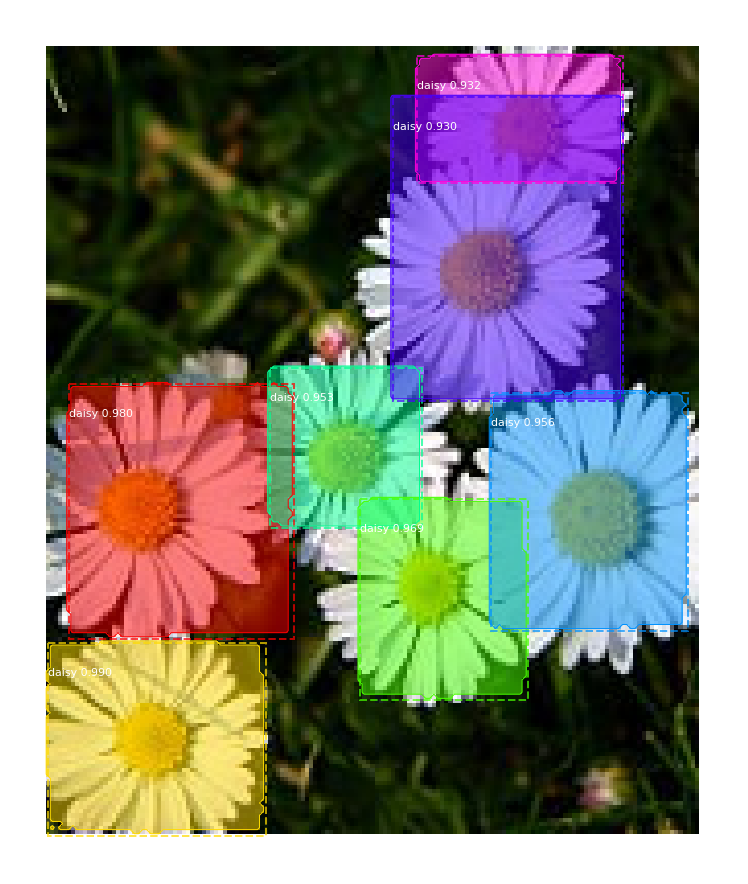

In [ ]:
import skimage.io
# Load a random image from the images folder
#file_names = next(os.walk())[2]
image = skimage.io.imread("../test1.jpg")

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
#print(results)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'])